In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx


sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

In [2]:
prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

prec_2 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.0],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.0,  0.        , -0.60606061,  1.51515152]])

Generate GP

In [3]:
cov_1 = np.linalg.inv(prec_1)
A = np.sqrt(np.diag(np.diag(cov_1)**(-1)))
corr_1 = np.dot(A,cov_1).dot(A)
prec_1_corr = np.linalg.inv(corr_1)


cov_2 = np.linalg.inv(prec_2)
A = np.sqrt(np.diag(np.diag(cov_2)**(-1)))
corr_2 = np.dot(A,cov_2).dot(A)
prec_2_corr = np.linalg.inv(corr_2)
prec_1_corr

array([[ 1.33141609,  0.        , -0.53425134,  0.45333496],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.53425134,  0.        ,  1.22500932, -0.28556936],
       [ 0.45333496,  0.        , -0.28556936,  1.16498908]])

# Test

True
[[ 1.          0.          0.36634099 -0.29933259]
 [ 0.          1.          0.          0.        ]
 [ 0.36634099  0.          1.          0.10257107]
 [-0.29933259  0.          0.10257107  1.        ]]
MVN
[[ 1.          0.03409771  0.32090304 -0.29099639]
 [ 0.03409771  1.          0.01508045 -0.06398506]
 [ 0.32090304  0.01508045  1.          0.12996512]
 [-0.29099639 -0.06398506  0.12996512  1.        ]]
U
[[ 1.          0.0346244   0.31187339 -0.28458202]
 [ 0.0346244   1.          0.01582562 -0.05333694]
 [ 0.31187339  0.01582562  1.          0.10089032]
 [-0.28458202 -0.05333694  0.10089032  1.        ]]


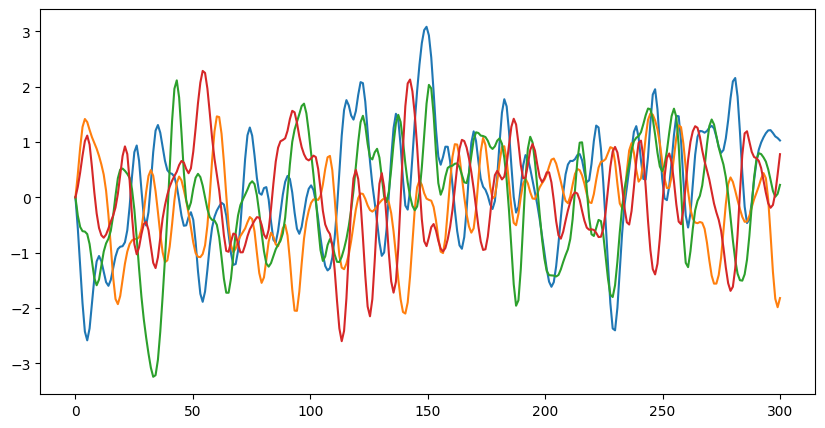

In [5]:
n = 300
t = np.linspace(0,n,n)
d = prec_1_corr.shape[0]
K = np.zeros(shape=(d, n,n))
for j in range(d):
    K[j] = pairwise_kernels(t.reshape(-1,1), metric = 'rbf',gamma = 0.05)


MVN1= np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(prec_1_corr), size=n)
MVN2 = np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(prec_1_corr), size=n)
MVN = np.vstack((MVN1,MVN2))
# generate u
u = norm.cdf(MVN,  scale = 1)

mu_1 = np.zeros(n)
x = np.zeros(shape=(n,d))
for i in range(n):
    for j in range(d):
        if i == 0:
            x[0,j] = 0
        else:
            reg =  1e-5*np.identity(i)
            tmp=K[j][i,i]- np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i] + reg)).dot(K[j][i,:i])
            scale = np.sqrt(tmp)
            if tmp <= 0:
                print(f"{i} {j}")
            loc = np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i]+reg)).dot(x[:i,j])
            x[i,j] = norm.ppf(u[i,j], loc= loc, scale = scale ) 
            

fig, ax = plt.subplots(1,1,figsize = (10,5))
for j in range(d):
    ax.plot(t,x[:,j])


print("True")
print(corr_1)
print("MVN")
print(np.corrcoef(MVN.T))
print("U")
print(np.corrcoef(u.T))

In [7]:
idx

array([], dtype=float64)

In [14]:
i

0

In [16]:
# Fit GPS..Assume already fitted
# Generate u....
w = 10
obs_per_graph = 100  
u_new = np.zeros(shape = (n,d))
for i in range(n): 

    lwr = np.max((i-w,0 ))
    upr= np.min((i+w,n))
    idx = np.array(range(lwr,upr,1))
    idx = idx[idx != i]
    for j in range(d):
        reg =  1e-5*np.identity(len(idx))
        loc = 0.0+np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(x[idx,j])
        scale = np.sqrt(K[j][i,i]- np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(K[j][i,idx]))
        u_new[i,j] = norm.cdf(x[i,j], loc= loc, scale = scale ) 

print("corr u")
print(np.corrcoef(u_new.T))

# get x
x_new = norm.ppf(u_new)
print("corr x_new")
print(np.corrcoef(x_new.T))
print("corr true")
print(corr_1)

# Fit dygraph

dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*0.12, kappa = obs_per_graph*0.2, tol = 1e-10)
dg_opt1.fit(x_new, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(x_new.shape[0]))
print("Estimated")
print(np.round(dg_opt1.theta[0],2))
print("True")
print(prec_1_corr)

cov = GraphicalLasso(alpha=0.25).fit(x_new[:obs_per_graph])
print("glasso")
print(np.round(cov.precision_,2))

corr u
[[ 1.          0.08021537  0.39658983 -0.19808356]
 [ 0.08021537  1.          0.10399806  0.06695316]
 [ 0.39658983  0.10399806  1.          0.05709803]
 [-0.19808356  0.06695316  0.05709803  1.        ]]
corr x_new
[[ 1.          0.05839709  0.42141936 -0.24368989]
 [ 0.05839709  1.          0.13151657  0.04505415]
 [ 0.42141936  0.13151657  1.          0.008617  ]
 [-0.24368989  0.04505415  0.008617    1.        ]]
corr true
[[ 1.          0.          0.36634099 -0.29933259]
 [ 0.          1.          0.          0.        ]
 [ 0.36634099  0.          1.          0.10257107]
 [-0.29933259  0.          0.10257107  1.        ]]


Error 1.03E-10:   3%|▎         | 302/10000 [00:01<01:02, 156.12it/s]


Estimated
[[ 0.62  0.   -0.24  0.08]
 [ 0.    0.45 -0.04 -0.  ]
 [-0.24 -0.04  0.77 -0.  ]
 [ 0.08 -0.   -0.    0.46]]
True
[[ 1.33141609  0.         -0.53425134  0.45333496]
 [ 0.          1.          0.          0.        ]
 [-0.53425134  0.          1.22500932 -0.28556936]
 [ 0.45333496  0.         -0.28556936  1.16498908]]
glasso
[[ 0.52  0.   -0.18  0.03]
 [ 0.    0.42 -0.   -0.  ]
 [-0.18 -0.    0.84 -0.  ]
 [ 0.03 -0.   -0.    0.43]]


# Run

In [17]:
kappas = np.linspace(0.01,1, 15)
gammas = [0.05,0.1, 0.5, 1]
alphas =np.linspace(0.01, 0.4,15)
pbar = tqdm.tqdm(total = len(kappas)*len(gammas)*len(alphas))
obs_per_graph = 100
for gamma in gammas:
    pbar.set_description(f"gamma {gamma}")
    n = 300
    t = np.linspace(0,2*n,2*n)
    d = prec_1_corr.shape[0]
    K = np.zeros(shape=(d, 2*n,2*n))
    for j in range(d):
        K[j] = pairwise_kernels(t.reshape(-1,1), metric = 'rbf',gamma = gamma)


    MVN1= np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(prec_1_corr), size=n)
    MVN2 = np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(prec_1_corr), size=n)
    MVN = np.vstack((MVN1,MVN2))
    # generate u
    u = norm.cdf(MVN,  scale = 1)

    x = np.zeros(shape=(2*n,d))
    for i in range(2*n):
        for j in range(d):
            if i == 0:
                x[0,j] = 0
            else:
                reg =  1e-5*np.identity(i)
                tmp=K[j][i,i]- np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i] + reg)).dot(K[j][i,:i])
                scale = np.sqrt(tmp)
                if tmp <= 0:
                    print(f"{i} {j}")
                loc = np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i]+reg)).dot(x[:i,j])
                x[i,j] = norm.ppf(u[i,j], loc= loc, scale = scale ) 

    u_new = np.zeros(shape = (2*n,d))

    for i in range(2*n): 
        w = 20
        k = int(i/100)
        lwr = np.max((i-w,k*obs_per_graph ))
        upr= np.min((i+w,((k+1)*obs_per_graph)))
        idx = np.array(range(lwr,upr,1))
        idx = idx[idx != i]
        for j in range(d):
            reg =  1e-5*np.identity(len(idx))
            loc = 0.0+np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(x[idx,j])
            scale = np.sqrt(K[j][i,i]- np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(K[j][i,idx]))
            u_new[i,j] = norm.cdf(x[i,j], loc= loc, scale = scale )

    x_new = norm.ppf(u_new)

    kappas = np.linspace(0.01,1, 15)
    out_dict = {}
    out_dict['theta'] = {s:[] for s in range(len(kappas))}
    out_dict['prec'] = [prec_1_corr] * 3 + [prec_2_corr]*3
    out_dict['gamma'] = 'gamma'
    out_dict['reg'] = 1e-5
    out_dict['kappas'] = kappas
    out_dict['alphas'] = alphas

    for cnt, kappa in enumerate(kappas):
        for alpha in alphas:

            obs_per_graph = 100  
            dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = 1e-10)
            dg_opt1.fit(x_new, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(x_new.shape[0]), verbose=False)
            out_dict['theta'][cnt].append(dg_opt1.theta)

            pbar.update()

    import pickle
    with open(f'../data/GP_test/GP_d_{d}_n_{n}_gamma_{gamma}.pkl', 'wb') as handle:
        pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

gamma 1: 100%|██████████| 900/900 [05:48<00:00, 11.55it/s]    

gamma 1: 100%|██████████| 900/900 [05:59<00:00, 11.55it/s]

In [19]:
def plot_metric(dict_name, kappa_vals, bbox_to_anchor = (1,1)):
        # Plot precision list 
    fig, ax = plt.subplots(1,len(kappa_vals), figsize = (5*len(kappa_vals),5))
    dict_name['alpha'] = alphas
    dict_name['kappa'] = kappas
    for i, k_idx in enumerate(kappa_vals):
        metric_zo = []
        metric_l1 = []
        metric_f = []
        for a in range(len(dict_name['alpha'])):
            loss = np.mean([calc_one_zero_error(dict_name['prec'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec']))])
            metric_zo.append(loss)

            loss = np.mean([scipy.linalg.norm(dict_name['prec'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro')/scipy.linalg.norm(dict_name['prec'][k], ord = 'fro') for k in range(len(dict_name['prec']))])
            metric_f.append(loss)

            loss = np.mean([scipy.linalg.norm(dict_name['prec'][k]- dict_name['theta'][a][k_idx][k],ord = 1)/scipy.linalg.norm(dict_name['prec'][k], ord = 1) for k in range(len(dict_name['prec']))])
            metric_l1.append(loss)

        if len(kappa_vals) == 1:
            ax.plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax.plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax.plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax.set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax.set_xlabel("alpha", fontdict = {'fontsize':24})
            ax.set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax.set_ylim((0,1))
            ax.tick_params(axis='both', which='major', labelsize=20)
            legend  = ax.legend(title = "Metric",fontsize = 14, bbox_to_anchor = bbox_to_anchor)
            legend.get_title().set_fontsize('18')


        else:
            ax[i].plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax[i].plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax[i].plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax[i].set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax[i].set_xlabel("alpha", fontdict = {'fontsize':24})
            if i == 0:
                ax[i].set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax[i].set_ylim((0,1))
            if i == len(kappa_vals)-1:
                #ax[i].legend(bbox_to_anchor = (1.4,1))
                legend  = ax[i].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
                legend.get_title().set_fontsize('18')

            ax[i].tick_params(axis='both', which='major', labelsize=20)


    







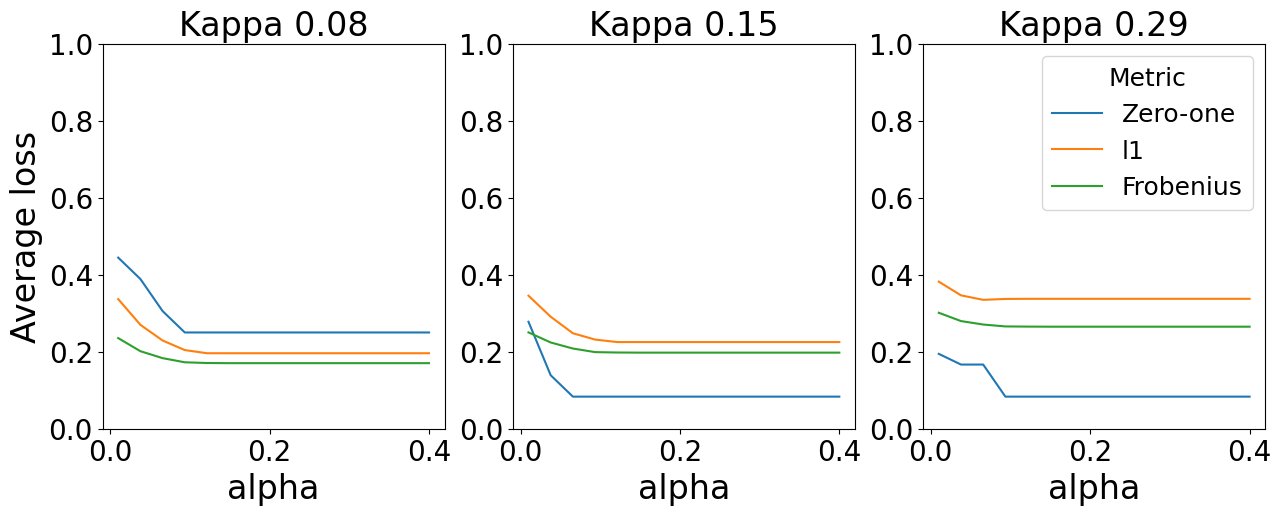

In [20]:
plot_metric(out_dict, [1,2,4])